In [2]:
library(ggplot2)

In [45]:
N <- 10000
a <- 0.012
b <- -0.09
k <- function(n=1){
        k<-runif(n,0.16,0.25)
        return(k)
        }
max_s_prop <- 0.7
age_max <- 70
age_step <- 1
N_iter=10

In [46]:
multi_sim <- function(N,a,b,k,max_s_prop,age_max,age_step,N_iter){
    multipop<-NA
    for(replicats in 1:N_iter){
        pop <- matrix(,nrow=4,ncol=age_max)
        rownames(pop)<-c("age","Smurf_prop","n_NS","n_S")
        pop[1,]<- seq(0,age_max-1,age_step)
        cbind.na <- function(x, y){
            n <- max(length(x), length(y))
            length(x) <- n              
            length(y) <- n
            combined<-cbind(x,y)
            combined[which(is.na(combined))]<-0
            return(combined)
        }

        Smurf <- function(age){
            age_func <- a*age+b
            smurf_prop <- ifelse(age_func>0, ifelse(age_func<max_s_prop,runif(1,0,age_func*2),runif(1,0,max_s_prop)),0)
            return(smurf_prop)
        }

    pop[3,1]<-N
    for(i in pop[1,]){pop[2,i]<-Smurf(i)}
    pop[4,1]<-round(pop[3,1]*pop[2,1], 0)
    i=0
    for(j in 2:length(pop[2,])){
       i=i+1 
       pop[4,j]<-round(pop[3,i]*pop[2,j] ,0)
       pop[3,j]<-pop[3,i]-pop[4,j] 
    }
    pop<-pop[,-length(pop[1,])]
    #pop

    kill_Smurfs <- function(n_S){
        dyingSmurfs <- NA
        dyingSmurfs[1]<-round(n_S-n_S*exp(-k()),0)
        i<-1
        while(n_S>0){
            i=i+1
            n_S<-dyingSmurfs[i-1]
            dyingSmurfs[i]<-round(n_S-n_S*exp(-k()),0)
        }
        return(dyingSmurfs)
    }


Smurf_death<-kill_Smurfs(pop[4,1])
length(Smurf_death)<-10; Smurf_death[which(is.na(Smurf_death))]<-0
for(i in pop[4,2:length(pop[4,])]){
    Smurf_death<-cbind.na(Smurf_death,kill_Smurfs(i))
}
Smurf_death<-cbind(pop[4,],t(Smurf_death))
Smurf_death[is.na(Smurf_death)]<-0
Smurf_death<-as.data.frame(Smurf_death)
rownames(Smurf_death)<-pop[1,]
colnames(Smurf_death)<-seq(1:length(Smurf_death[1,]))
#Smurf_death

Smurfs_dyn<-NA
length(Smurfs_dyn)<-80
for(i in 1:length(Smurf_death[,1])){
    temp<-c(rep(NA,i-1),Smurf_death[i,])
    length(temp)<-80
    Smurfs_dyn<-rbind(Smurfs_dyn,temp)
    }
Smurfs_dyn<-as.data.frame(Smurfs_dyn[-1,])
colnames(Smurfs_dyn)<-seq(1,80,1)
rownames(Smurfs_dyn)<-pop[1,]
Smurfs_dyn[,1:80][Smurfs_dyn[,1:80] == "NULL"] <- 0
#Smurfs_dyn

Smurfs_alive<-NA
length(Smurfs_alive)<-80
for(i in 1:80){Smurfs_alive[i]=sum(as.numeric(Smurfs_dyn[,i]),na.rm=TRUE)}
pop<-rbind(pop,t(Smurfs_alive[1:69]))
rownames(pop)<-c("age","Smurf_prop","n_NS","n_S","S_alive")
#pop

Smurf_surv<-as.data.frame(apply(Smurf_death,2,sum))
Smurf_surv<-cbind(as.numeric(colnames(Smurf_death)),Smurf_surv)
rownames(Smurf_surv)<-NULL
colnames(Smurf_surv)<-c("timeAsSmurf","Smurfs_alive")
#head(Smurf_surv)
        multipop<-rbind(multipop,pop)
#return(pop)
}
multipop<-multipop[-1,]
return(multipop)
}

In [47]:
suppressWarnings(multi_sim(N,a,b,k,max_s_prop,age_max,age_step, N_iter=2))

age,0,1,2,3,4,5,6,7.000000e+00,8.000000e+00,9.000000e+00,...,59.0000000,60.00000000,61.0000000,62.0000000,63.0000000,64.0000000,65.0000000,66.0000000,67.0000000,68.0000000
Smurf_prop,0,0,0,0,0,0,0,6.548778e-03,1.805697e-02,3.993967e-02,...,0.1826912,0.06386917,0.7030265,0.8982545,0.4759625,0.1384171,0.2189074,0.3146570,0.0940893,0.3379586
n_NS,10000,10000,10000,10000,10000,10000,10000,9.935000e+03,9.756000e+03,9.366000e+03,...,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
n_S,0,0,0,0,0,0,0,6.500000e+01,1.790000e+02,3.900000e+02,...,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
S_alive,0,0,0,0,0,0,0,6.500000e+01,1.920000e+02,4.300000e+02,...,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
age,0,1,2,3,4,5,6,7.000000e+00,8.000000e+00,9.000000e+00,...,59.0000000,60.00000000,61.0000000,62.0000000,63.0000000,64.0000000,65.0000000,66.0000000,67.0000000,68.0000000
Smurf_prop,0,0,0,0,0,0,0,3.770912e-03,1.687004e-02,5.819761e-02,...,0.5303135,0.02086103,0.8863180,0.3094322,0.9510938,0.7420028,0.5794692,0.5809197,0.6995616,0.5443430
n_NS,10000,10000,10000,10000,10000,10000,10000,9.962000e+03,9.794000e+03,9.224000e+03,...,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
n_S,0,0,0,0,0,0,0,3.800000e+01,1.680000e+02,5.700000e+02,...,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
S_alive,0,0,0,0,0,0,0,3.800000e+01,1.760000e+02,6.020000e+02,...,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


In [36]:
sims<-as.data.frame(t(sims))
age_max<-min(sims$age[which(sims$n_NS<1)])

In [ ]:
ggplot(multipop)+
    geom_line(aes(age,n_NS), linetype="dashed")+
    geom_line(aes(age,n_S), color="blue")+
    geom_line(aes(age,S_alive), color="dark blue", linetype="dashed")+
    geom_line(aes(age,n_NS+S_alive))+
    xlim(0,age_max)

In [38]:
head(sims)

age,Smurf_prop,n_NS,n_S,S_alive,age,Smurf_prop,n_NS,n_S,S_alive
0,0,10000,0,0,0,0,10000,0,0
1,0,10000,0,0,1,0,10000,0,0
2,0,10000,0,0,2,0,10000,0,0
3,0,10000,0,0,3,0,10000,0,0
4,0,10000,0,0,4,0,10000,0,0
5,0,10000,0,0,5,0,10000,0,0


`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
“Removed 25 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 25 rows containing missing values (geom_point).”Warning message:
“Removed 8 rows containing missing values (geom_smooth).”

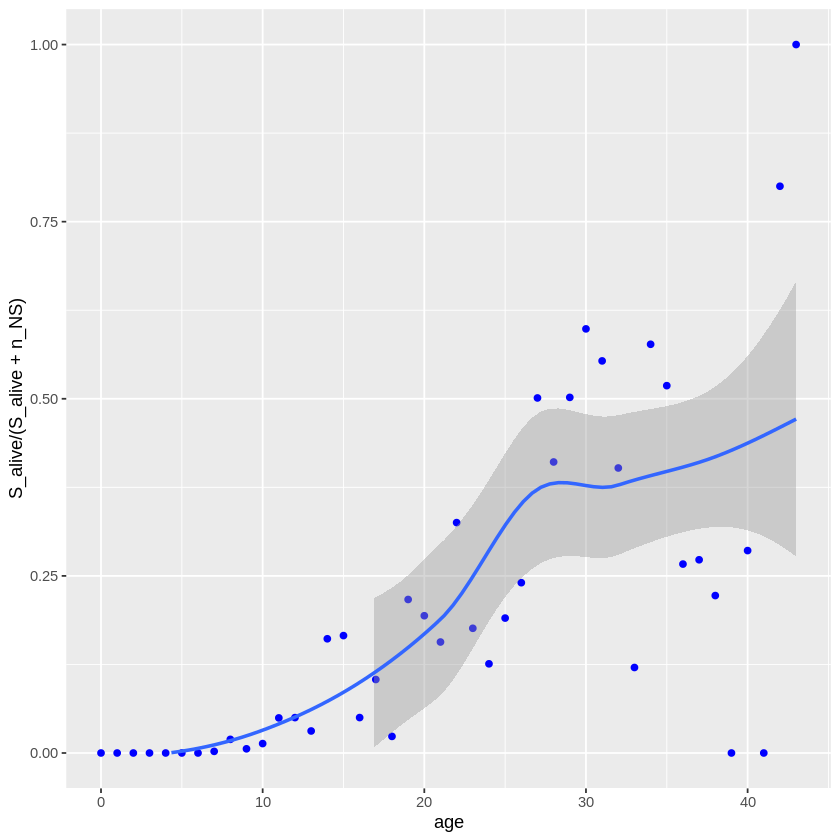

In [23]:
ggplot(pop)+
    geom_point(aes(x=age,y=S_alive/(S_alive+n_NS)), color="blue")+
    geom_smooth(aes(x=age,y=S_alive/(S_alive+n_NS)))+
    ylim(0,1)+
    xlim(0,age_max)  